# Setup

In [1]:
%%capture
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import scvi
import scipy
from scipy.stats import spearmanr

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

## Set data paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## import data

In [6]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
model = scvi.model.SCVI.load(f"{processedDataPath}/M_cell/scVI_models/combined_WT_fezf2KO_aireKO_all_genes", adata=adata)
tabulaMurisData = sc.read(f"{processedDataPath}/M_cell/h5ad_files/tabula_muris_expression_filtered_genes.h5ad")
TFs = list(pd.read_csv("../../mouse_ensemble_tfs_from_lambertetal_isyes.unique.csv", header=None)[1])
TFs = [i for i in TFs if i in adata.var_names]
TRAs = pd.read_csv("../../analysis/TRA_list.csv")["0"]
TRAs = [i for i in TRAs if i in adata.var_names]

INFO     File /mnt/iacchus/joe/processed_data//M_cell/scVI_models/combined_WT_fezf2KO_aireKO_all_genes/model.pt    
         already downloaded                                                                                        


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Methods

### plot gene list

In [7]:
def plot_gene_list(adata, gene_list, layer, obs_key=None, obs_list=None, save_path=None, *arg, **kwarg):
    vmin = []
    vmax = []
    for gene in gene_list:
        if obs_key is None:
            if scipy.sparse.issparse(adata.layers[layer]):
                data = np.asarray(adata[:, gene].layers[layer].todense())
            else:
                data = adata[:, gene].layers[layer]
        else:
            if scipy.sparse.issparse(adata.layers[layer]):
                data = np.asarray(adata[adata.obs[obs_key] == obs_list[0], gene].layers[layer].todense())
            else:
                data = adata[adata.obs[obs_key] == obs_list[0], gene].layers[layer]
        vmin.append(np.quantile(data, 0.01))
        vmax.append(np.quantile(data, 0.99))
    
    if save_path is not None:
        sc.settings.figdir = save_path.rsplit("/", 1)[0]
        file = save_path.rsplit("/", 1)[1]
    else:
        file=None
    if obs_key is None:
        sc.pl.umap(
            adata,
            color=gene_list,
            layer=layer,
            vmin=vmin,
            vmax=vmax,
            save=file,
            *arg, **kwarg
        )
    else:
        for obs in obs_list:
            sc.pl.umap(
                adata[adata.obs[obs_key] == obs],
                color=gene_list,
                layer=layer,
                vmin=vmin,
                vmax=vmax,
                save=f"{file}_{obs}.pdf",
                *arg, **kwarg
            )

### genotype gene expression

In [8]:
def genotype_gene_expression(
    adata, gene_list, genotype_list, highlight_genes, label_genes=[],
    cell_type_list=None, save_path=None, axis_lim=[10**-2, 10**2],
    figdim=(5.5,5),
):
    copy_adata = adata[:, gene_list]
        
    expression = pd.DataFrame(
        copy_adata.layers["scVI_normalized"],
        index=copy_adata.obs.index,
        columns=copy_adata.var_names
    )
    expression["genotype"] = copy_adata.obs.genotype
    expression = expression.groupby("genotype").mean().T
    plt.figure(figsize=figdim)
    sns.scatterplot(
        expression,
        y=expression[genotype_list[0]],
        x=expression[genotype_list[1]],
        linewidth=0,
        s=8,
        color="lightgrey"
    )
    highlightExpression = expression[(expression.index.isin(highlight_genes)) & (expression[genotype_list[1]] > expression[genotype_list[0]])]
    ax = sns.scatterplot(
        highlightExpression,
        y=highlightExpression[genotype_list[0]],
        x=highlightExpression[genotype_list[1]],
        linewidth=0,
        s=8,
        color="tab:red"
    )
    highlightExpression = expression[(expression.index.isin(highlight_genes)) & (expression[genotype_list[1]] < expression[genotype_list[0]])]
    ax = sns.scatterplot(
        highlightExpression,
        y=highlightExpression[genotype_list[0]],
        x=highlightExpression[genotype_list[1]],
        linewidth=0,
        s=8,
        color="tab:green"
    )
    for gene in label_genes:
        ax.text(
            y=expression[expression.index==gene][genotype_list[0]],
            x=expression[expression.index==gene][genotype_list[1]],
            s=gene,
            fontsize=12,
            color="blue"
        )
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black", linestyle="dashed")
    ax.grid(False)
    plt.xlim(axis_lim[0], axis_lim[1])
    plt.ylim(axis_lim[0], axis_lim[1])
    plt.xscale("log")
    plt.yscale("log")
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

### Volcano plot method

In [9]:
def volcano_plot(de, highlight_genes, label_genes=[], highlight_color="red", save_path=None):
    ax = sns.scatterplot(
        x=de.lfc_mean,
        y=de.bayes_factor,
        linewidth=0,
        s=5,
        color="lightgrey",
    )
    ax.grid(False)
    ax.set(xlabel='lfc_mean_WT_vs_KO')
    sns.scatterplot(
        x=de[de.index.isin(highlight_genes)].lfc_mean,
        y=de[de.index.isin(highlight_genes)].bayes_factor,
        linewidth=0,
        s=5,
        color=highlight_color,
    )
    plt.axhline(y=2, color="black", linestyle="dashed")
    plt.axvline(x=-1, color="black", linestyle="dashed")
    plt.axvline(x=1, color="black", linestyle="dashed")
    for gene in label_genes:
        plt.text(
            de[de.index == gene].lfc_mean,
            de[de.index == gene].bayes_factor,
            s=gene,
            color="tab:blue",
            fontdict={"fontsize":12},
        )
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

### num expressed genes plotting

In [10]:
def num_expressed_genes_umaps(
    adata, gene_list, genotype_list, key, threshold=1,
    genotype_key="genotype", layer="scVI_normalized", save_path=None,
    *args, **kwargs
):
    expressionData = pd.DataFrame(
        adata[:, gene_list].layers[layer],
        index=adata.obs.index,
        columns=adata[:, gene_list].var_names
    )
    num_induced = (expressionData > threshold).sum(axis=1)
    frac_induced = num_induced/len(gene_list)
    adata.obs[f"{key}_num"] = num_induced
    adata.obs[f"{key}_frac"] = frac_induced
    
    obs_list = [f"{key}_num", f"{key}_frac"]
    vmin=[]
    vmax=[]
    for obs in obs_list:
        vmin.append(np.quantile(adata[adata.obs[genotype_key]==genotype_list[0]].obs[obs], 0.01))
        vmax.append(np.quantile(adata[adata.obs[genotype_key]==genotype_list[0]].obs[obs], 0.99))
    for genotype in genotype_list:
        if save_path is not None:
            prefix = save_path.rsplit("/", 1)[1]
            file = f"_{prefix}_{key}_{genotype}.pdf"
            sc.settings.figdir = save_path.rsplit("/", 1)[0]
        else:
            file=None
        sc.pl.umap(
            adata[adata.obs[genotype_key]==genotype],
            color=obs_list,
            vmin=vmin,
            vmax=vmax,
            save=file,
        )
    
def num_expressed_genes_boxplots(
    adata, gene_list, genotype_list, key, threshold=1, genotype_key="genotype",
    cell_type_key="cell_type", layer="scVI_normalized", save_path=None,
    cell_type_list=None, *args, **kwargs
):
    adata_copy = adata[adata.obs[genotype_key].isin(genotype_list)]
    expressionData = pd.DataFrame(
        adata_copy[:, gene_list].layers[layer],
        index=adata_copy.obs.index,
        columns=adata_copy[:, gene_list].var_names
    )
    num_induced = (expressionData > threshold).sum(axis=1)
    frac_induced = num_induced/len(gene_list)
    adata_copy.obs[f"{key}_num"] = num_induced
    adata_copy.obs[f"{key}_frac"] = frac_induced
        
    data=sc.get.obs_df(adata_copy, keys=[cell_type_key, f"{key}_num", f"{key}_frac", genotype_key])
    if cell_type_list is not None:
        data = data[data.cell_type.isin(cell_type_list)]
        data.cell_type.cat.remove_unused_categories(inplace=True)
        data.cell_type.cat.reorder_categories(cell_type_list, inplace=True)
    data.genotype.cat.reorder_categories(genotype_list, inplace=True)

    plt.figure(figsize=(8,4))
    ax = sns.boxplot(
        x=data[cell_type_key],
        y=data[f"{key}_num"],
        hue=data[genotype_key],
        *args, **kwargs,
    )
    ax.grid(False)
    plt.xticks(rotation=90)
    if save_path is not None:
        plt.savefig(f"{save_path}_num_genes_boxplot.pdf", bbox_inches="tight", dpi=300)
    plt.show()

    plt.figure(figsize=(8,4))
    ax = sns.boxplot(
        x=data[cell_type_key],
        y=data[f"{key}_frac"],
        hue=data[genotype_key],
        *args, **kwargs,
    )
    ax.grid(False)
    plt.xticks(rotation=90)
    if save_path is not None:
        plt.savefig(f"{save_path}_frac_genes_boxplot.pdf", bbox_inches="tight", dpi=300)
    plt.show()

### gene list enrichment

In [11]:
def gene_list_enrichment_umap(adata, gene_list, key, save_path=None):
    # Score gene list
    sc.tl.score_genes(adata, gene_list=gene_list, score_name=key)
    # Plot enrichment score on UMAP
    if save_path is not None:
        prefix = save_path.rsplit("/", 1)[1]
        file = f"_{prefix}_{key}.pdf"
        sc.settings.figdir = save_path.rsplit("/", 1)[0]
    else:
        file = None
    sc.pl.umap(
        adata,
        color=key,
        vmin=np.quantile(adata.obs[key], 0.01),
        vmax=np.quantile(adata.obs[key], 0.99),
        save=file,
    )
    
def gene_list_enrichment_boxplot(adata, gene_list, key, cell_type_list, cell_type_key="cell_type", save_path=None, *args, **kwargs):
    # Score gene list
    sc.tl.score_genes(adata, gene_list=gene_list, score_name=key)
    # Get scores and cell types to DF
    scores = pd.DataFrame({key: adata.obs[key], "cell_type": adata.obs[cell_type_key]})
    if cell_type_list is not None:
        # Subset on desires cell types and reorder
        scores = scores[scores.cell_type.isin(cell_type_list)]
        scores.cell_type.cat.remove_unused_categories(inplace=True)
        scores.cell_type.cat.reorder_categories(cell_type_list, inplace=True)
    
    # Boxplot of scores across cell types
    fig = plt.figure(figsize=(len(cell_type_list)*0.5,3))
    ax = sns.boxplot(
        x=scores.cell_type,
        y=scores[key],
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    ax.grid(False)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

### reference tissue expression

In [12]:
def reference_gene_tissue_expression(reference_adata, gene_list, key, tissue_list=None, save_path=None, tissue_key="tissue", *args, **kwargs):
    sc.tl.score_genes(reference_adata, gene_list=gene_list, score_name=key)
    plot_data = sc.get.obs_df(reference_adata, [tissue_key, key])
    if tissue_list is not None:
        plot_data = plot_data[plot_data[tissue_key].isin(tissue_list)]
        plot_data[tissue_key].cat.remove_unused_categories(inplace=True)
    plt.figure(figsize=(len(plot_data[tissue_key].unique())*0.5,3))
    ax=sns.boxplot(
        x=plot_data[tissue_key],
        y=plot_data[key],
        *args, **kwargs
    )
    ax.grid(False)
    plt.xticks(rotation=90)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

### gene list lfc heatmap

In [13]:
def gene_list_lfc_across_clusters(
    adata, gene_list, genotype_list, cell_type_list=None, save_path=None, genotype_key="genotype",
    layer="scVI_normalized", cell_type_key="cell_type", cbar_args=[1, 0.5, 0.01, 0.5], *args, **kwargs
):
    control_data = adata[adata.obs[genotype_key] == genotype_list[0], gene_list]
    condition_data = adata[adata.obs[genotype_key] == genotype_list[1], gene_list]
    
    if scipy.sparse.issparse(control_data.layers[layer]):
        control_expression = control_data.layers[layer].todense()
    else:
        control_expression = control_data.layers[layer]
    control_expression = pd.DataFrame(
        control_expression,
        index=control_data.obs.index,
        columns=control_data.var_names
    )
    # control_expression = control_expression[control_expression > 0.05]
    control_expression["cell_type"] = control_data.obs[cell_type_key]
    control_expression = control_expression.groupby("cell_type").mean()
    
    if scipy.sparse.issparse(condition_data.layers[layer]):
        condition_expression = condition_data.layers[layer].todense()
    else:
        condition_expression = condition_data.layers[layer]
    condition_expression = pd.DataFrame(
        condition_expression,
        index=condition_data.obs.index,
        columns=condition_data.var_names
    )
    # condition_expression = condition_expression[condition_expression > 0.05]
    condition_expression["cell_type"] = condition_data.obs[cell_type_key]
    condition_expression = condition_expression.groupby("cell_type").mean()
    
    lfc = np.log2(control_expression/condition_expression)
    
    if cell_type_list is not None:
        lfc = lfc[lfc.index.isin(cell_type_list)]
    
    cg = sns.clustermap(
        lfc,
        *args, **kwargs,
    )
    cg.ax_cbar.set_position(cbar_args)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel("")
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Whole dataset DE genes

In [14]:
allClustersDE = model.differential_expression(
    groupby="genotype",
    group1="WT",
    group2="Fezf2_KO"
)

DE...: 100%|██████████| 1/1 [00:08<00:00,  8.26s/it]


## Filter highly DE genes

In [15]:
filteredAllClustersDE = allClustersDE[allClustersDE.bayes_factor > 2].copy()
filteredAllClustersDE = filteredAllClustersDE[abs(filteredAllClustersDE.lfc_mean) > 1]
filteredAllClustersDE = filteredAllClustersDE[(filteredAllClustersDE.non_zeros_proportion1 > 0.05) | (filteredAllClustersDE.non_zeros_proportion2 > 0.05)]

In [16]:
# Filter genes with low average normalized expression
expressionFiltered = pd.DataFrame(
    pd.DataFrame(
        adata[:, filteredAllClustersDE.index].layers["scVI_normalized"],
        columns=filteredAllClustersDE.index
    ).quantile(0.99)
)
expressionFiltered = expressionFiltered[expressionFiltered[0.99] > 1]
filteredAllClustersDE = filteredAllClustersDE[filteredAllClustersDE.index.isin(expressionFiltered.index)]

## Save CSVs

In [17]:
allClustersDE.to_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters.csv")
filteredAllClustersDE.to_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters_filtered.csv")

# Feature plots

In [18]:
filteredAllClustersDE = filteredAllClustersDE.sort_values(by="lfc_mean", ascending=False)

## Down in KO

In [19]:
allClustersDownKO = filteredAllClustersDE[filteredAllClustersDE.lfc_mean > 0]

In [20]:
len(allClustersDownKO)

658

## Up in KO

In [21]:
allClustersUpKO = filteredAllClustersDE[filteredAllClustersDE.lfc_mean < 0]
allClustersUpKO = allClustersUpKO.sort_values(by="lfc_mean")

In [22]:
len(allClustersUpKO)

418

# Volcano plots

In [23]:
filteredAllClustersDE.head(20)

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Krt84,0.9628,0.0372,3.253537,0.000017,0.000003,0.0,0.25,3.306376,3.323353,3.934717,...,0.251778,0.029296,0.060882,0.013099,0.144338,0.014598,True,WT vs Fezf2_KO,WT,Fezf2_KO
Nefh,0.9570,0.0430,3.102603,0.000032,0.000009,0.0,0.25,3.217627,3.455088,4.053741,...,0.379582,0.098873,0.065427,0.017746,0.208218,0.044661,True,WT vs Fezf2_KO,WT,Fezf2_KO
AC160336.1,0.9596,0.0404,3.167687,0.000047,0.000003,0.0,0.25,3.105676,3.376212,2.140660,...,0.793774,0.054085,0.346630,0.047465,0.487980,0.033677,True,WT vs Fezf2_KO,WT,Fezf2_KO
Gm13305,0.9678,0.0322,3.403059,0.000405,0.000013,0.0,0.25,3.094616,4.004896,3.766981,...,6.971256,0.129437,0.555290,0.101972,3.988780,0.074489,True,WT vs Fezf2_KO,WT,Fezf2_KO
Pck1,0.9648,0.0352,3.310874,0.000034,0.000004,0.0,0.25,2.957592,3.016984,2.832707,...,0.398541,0.018310,0.073680,0.006056,0.226839,0.009903,True,WT vs Fezf2_KO,WT,Fezf2_KO
Map1a,0.9646,0.0354,3.305001,0.000036,0.000005,0.0,0.25,2.930825,3.053893,2.830805,...,0.324022,0.042394,0.144848,0.028451,0.204237,0.020385,True,WT vs Fezf2_KO,WT,Fezf2_KO
Sis,0.9630,0.0370,3.259135,0.000043,0.000007,0.0,0.25,2.902258,3.012818,3.897144,...,0.429460,0.042817,0.059805,0.014366,0.241872,0.024187,True,WT vs Fezf2_KO,WT,Fezf2_KO
Il25,0.9662,0.0338,3.352910,0.000021,0.000003,0.0,0.25,2.862933,2.815945,2.370587,...,0.153340,0.021127,0.052090,0.008732,0.107136,0.014958,True,WT vs Fezf2_KO,WT,Fezf2_KO
Calb1,0.9632,0.0368,3.264763,0.000027,0.000006,0.0,0.25,2.850849,2.920117,3.557879,...,0.447521,0.028592,0.112792,0.013239,0.255848,0.014157,True,WT vs Fezf2_KO,WT,Fezf2_KO
Penk,0.9636,0.0364,3.276107,0.000042,0.000008,0.0,0.25,2.844758,2.981103,2.666222,...,0.306082,0.037465,0.051313,0.014507,0.175813,0.020181,True,WT vs Fezf2_KO,WT,Fezf2_KO


## All genes

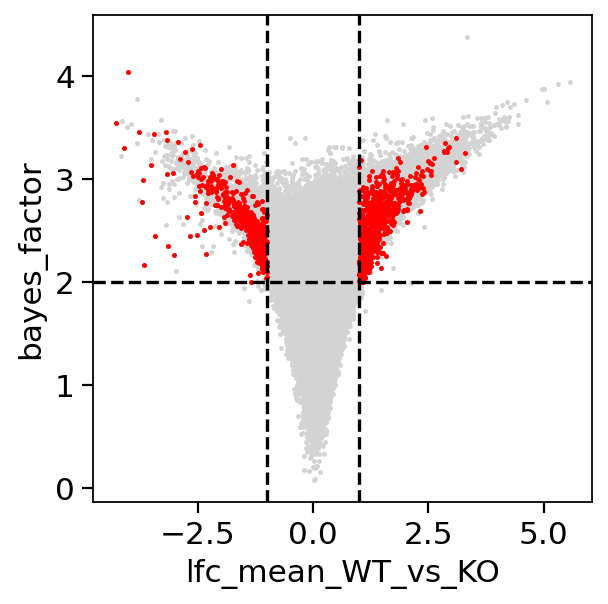

In [24]:
volcano_plot(
    allClustersDE,
    highlight_genes=filteredAllClustersDE.index,
    #label_genes=,
    save_path="../../analysis/Paper figs/1 (Fezf2 KO)/1H_de_genes.pdf"
)

# DE TFs

In [25]:
allClustersTFs = filteredAllClustersDE[filteredAllClustersDE.index.isin(TFs)]
allClustersTFs.to_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters_filtered_TFs.csv")
len(allClustersTFs)

65

In [26]:
allClustersTFs.head(15)

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Hmx3,0.9560,0.0440,3.078568,0.000032,0.000007,0.0,0.25,2.367553,2.516263,2.310980,...,0.221516,0.016901,0.103941,0.009577,0.137203,0.008994,True,WT vs Fezf2_KO,WT,Fezf2_KO
Hmx2,0.9552,0.0448,3.059712,0.000023,0.000007,0.0,0.25,2.243132,2.356544,2.950177,...,0.123917,0.012817,0.062197,0.006620,0.083238,0.007036,True,WT vs Fezf2_KO,WT,Fezf2_KO
Hoxc11,0.9436,0.0564,2.817233,0.000027,0.000007,0.0,0.25,2.084683,2.153358,2.273218,...,0.275878,0.016761,0.113390,0.008873,0.168621,0.009482,True,WT vs Fezf2_KO,WT,Fezf2_KO
Aire,0.9410,0.0590,2.769406,0.000297,0.000124,0.0,0.25,1.721106,1.661935,3.066543,...,5.160318,2.468282,0.552599,0.304366,2.929606,1.172462,True,WT vs Fezf2_KO,WT,Fezf2_KO
Myb,0.9308,0.0692,2.599043,0.000064,0.000020,0.0,0.25,1.696584,1.747200,1.618766,...,0.799218,0.199860,0.312721,0.111127,0.443926,0.108147,False,WT vs Fezf2_KO,WT,Fezf2_KO
Mxd1,0.9368,0.0632,2.696165,0.000301,0.000101,0.0,0.25,1.619307,1.769966,1.963318,...,4.806284,1.654747,0.776329,0.474366,2.982349,0.980741,False,WT vs Fezf2_KO,WT,Fezf2_KO
Tfcp2l1,0.9290,0.0710,2.571429,0.000075,0.000033,0.0,0.25,1.543090,1.581472,2.010603,...,0.992500,0.405353,0.351355,0.154789,0.622044,0.222580,False,WT vs Fezf2_KO,WT,Fezf2_KO
Cdx1,0.9348,0.0652,2.662873,0.000141,0.000055,0.0,0.25,1.537298,1.679224,2.106911,...,2.649901,0.992399,0.600323,0.272817,1.479920,0.465293,False,WT vs Fezf2_KO,WT,Fezf2_KO
Tfap2b,0.9376,0.0624,2.709758,0.000112,0.000045,0.0,0.25,1.495827,1.606177,2.660636,...,2.083018,0.355916,0.294899,0.057324,1.196386,0.188730,False,WT vs Fezf2_KO,WT,Fezf2_KO
Etv3,0.9206,0.0794,2.450527,0.000121,0.000041,0.0,0.25,1.440105,1.513355,1.553156,...,1.970207,0.633101,0.627714,0.337887,1.195086,0.379105,False,WT vs Fezf2_KO,WT,Fezf2_KO


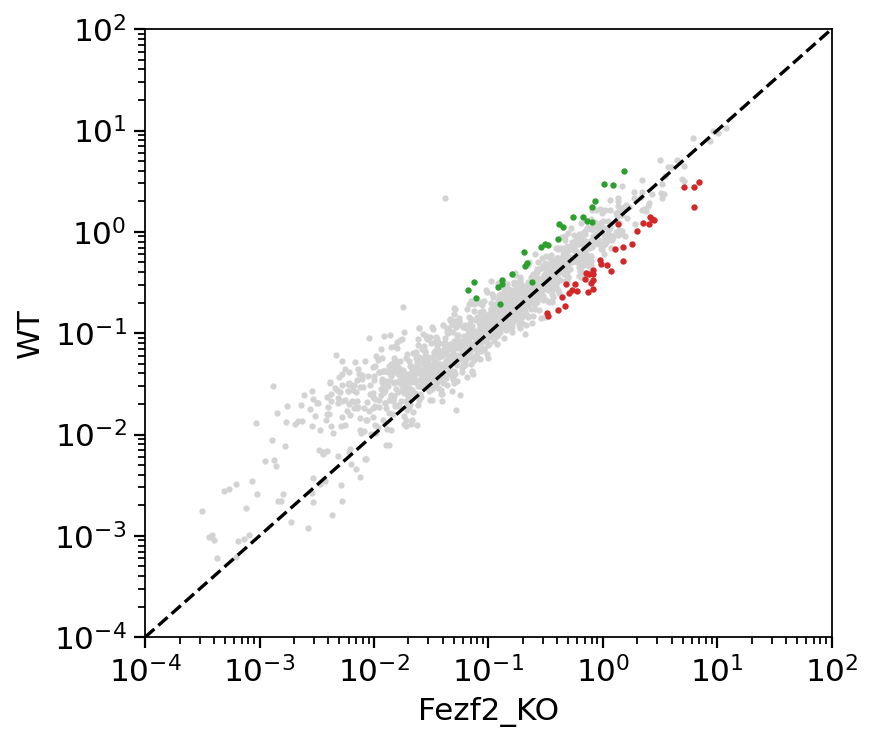

In [27]:
genotype_gene_expression(
    adata,
    gene_list=TFs,
    genotype_list=["WT", "Fezf2_KO"],
    highlight_genes=allClustersTFs.index,
    cell_type_list=None,
    axis_lim=[10**-4, 10**2],
    save_path="../../analysis/Paper figs/1 (Fezf2 KO)/1J_Fezf2_reg_TFs.pdf"
)

# Number of DE genes expressed

## Down in Fezf2 KO

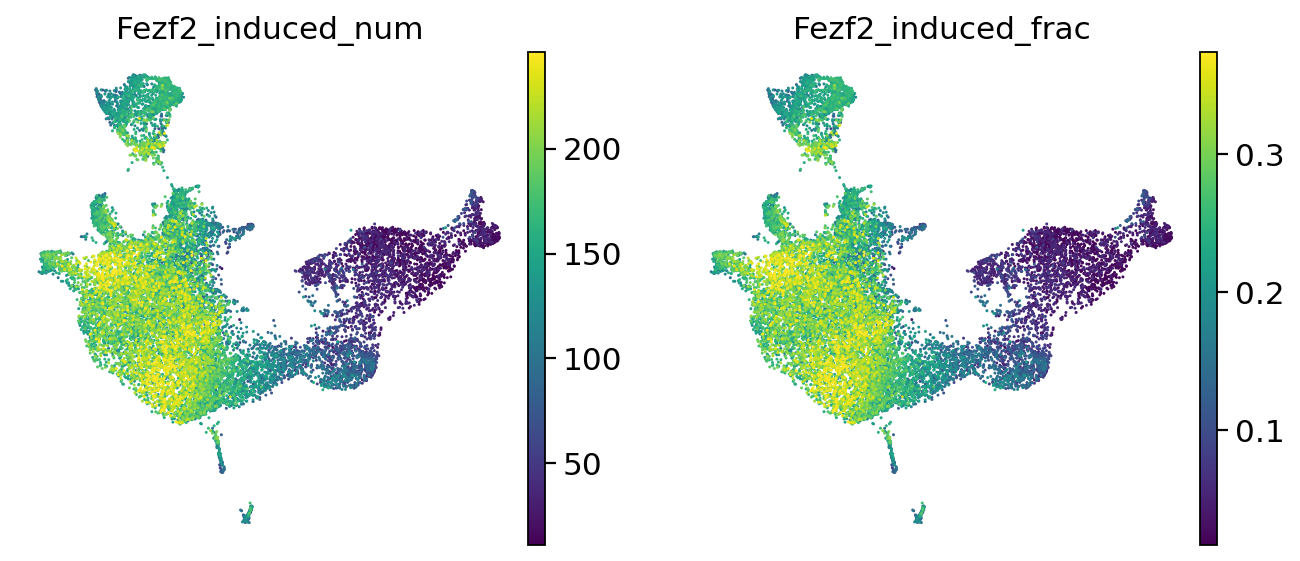

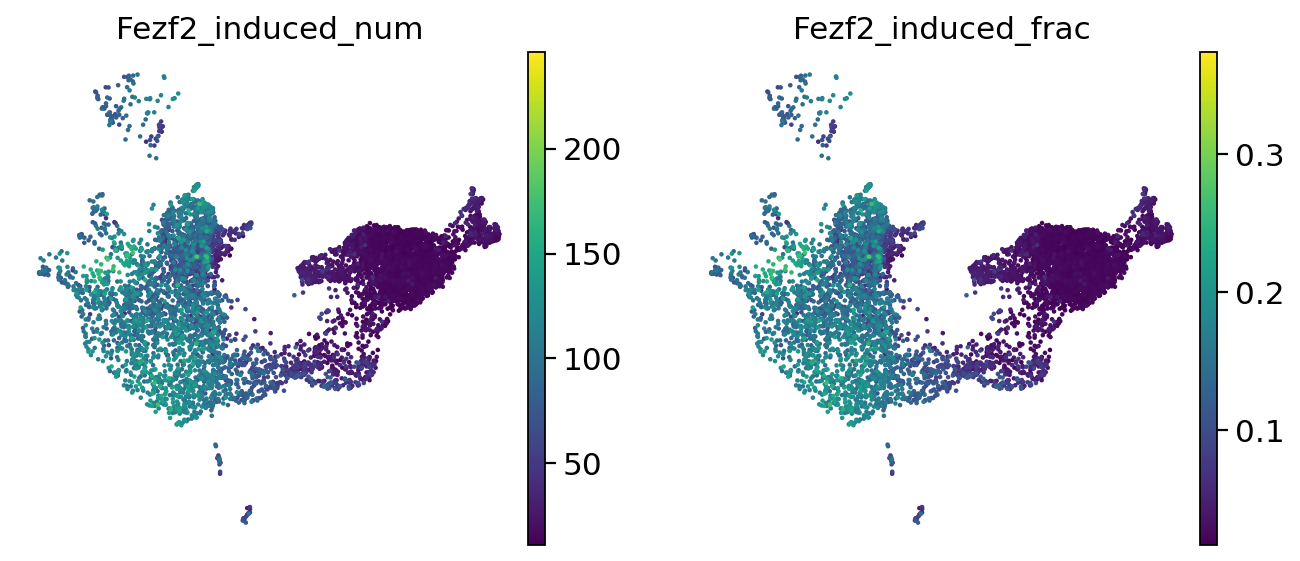

In [29]:
num_expressed_genes_umaps(
    adata,
    allClustersDownKO.index,
    genotype_list=["WT", "Fezf2_KO"],
    key="Fezf2_induced",
    save_path="../../analysis/Paper figs/S2 (Fezf2 KO)/S2C"
)

## Up in Fezf2 KO

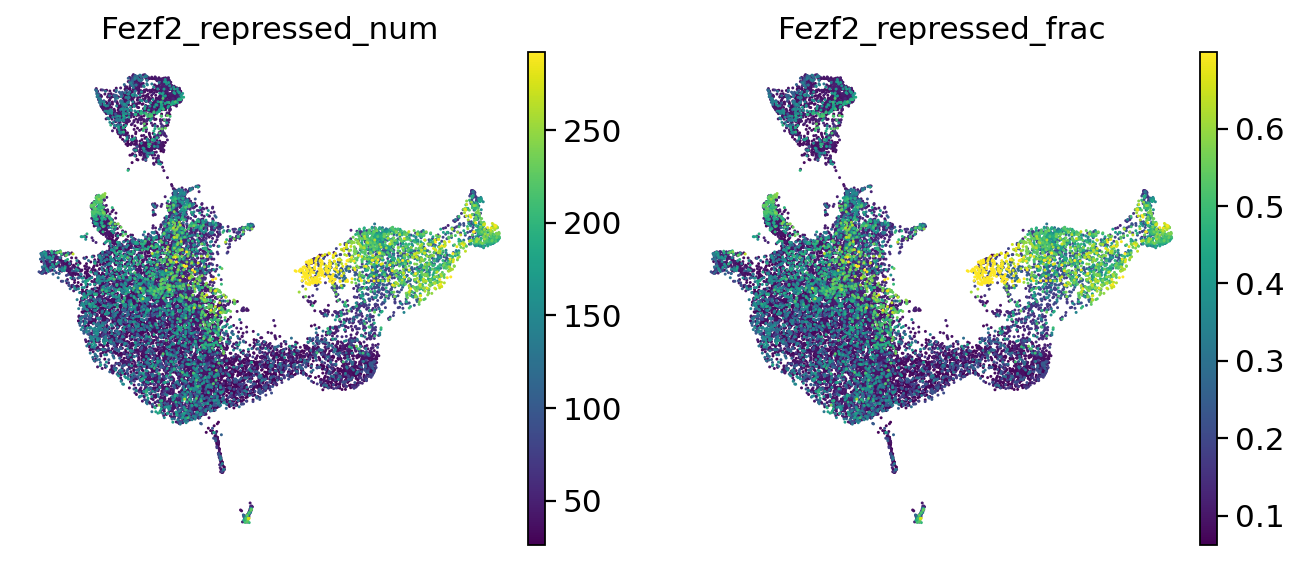

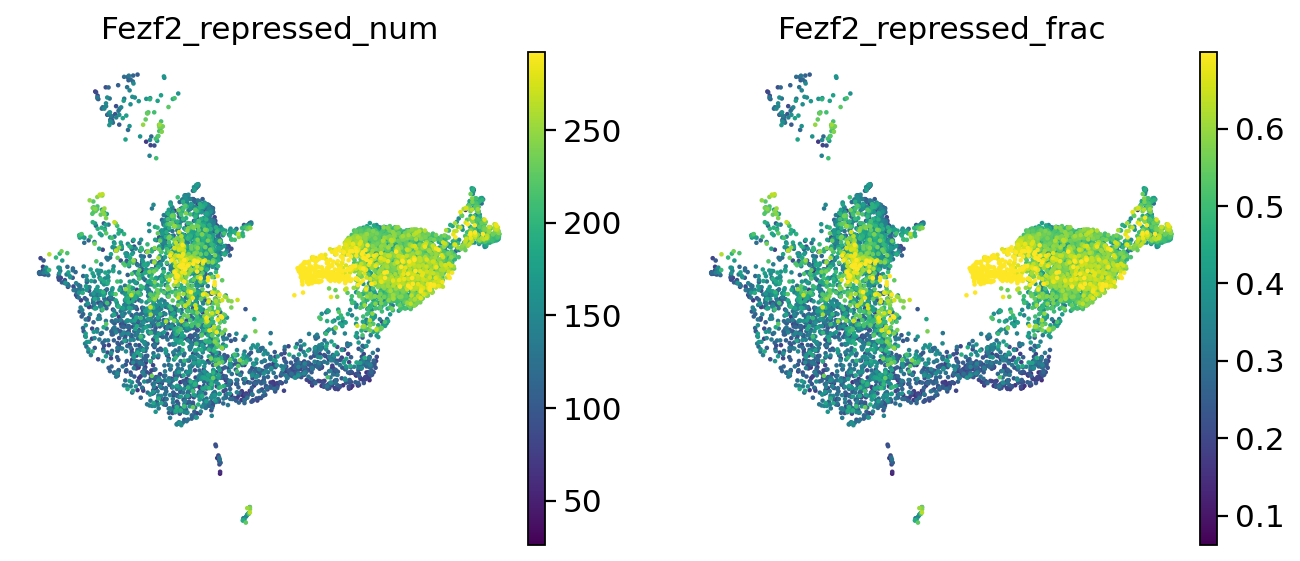

In [30]:
num_expressed_genes_umaps(
    adata,
    allClustersUpKO.index,
    genotype_list=["WT", "Fezf2_KO"],
    key="Fezf2_repressed",
    save_path="../../analysis/Paper figs/S2 (Fezf2 KO)/S2C"
)

# Enrichment of DE gene expression

## Down in Fezf2 KO

### All clusters

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


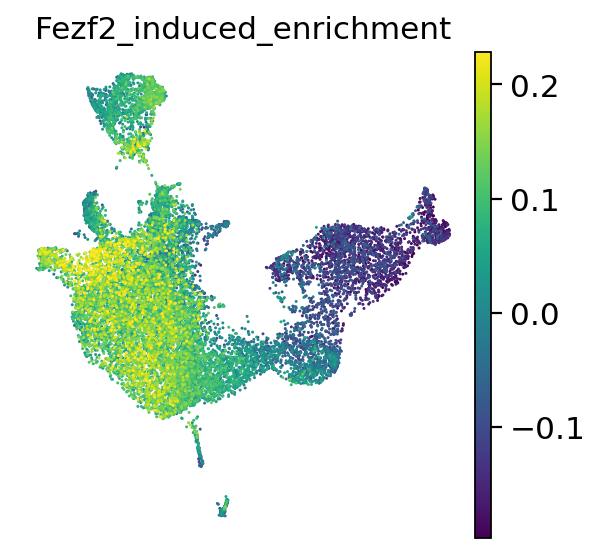

In [31]:
gene_list_enrichment_umap(
    adata[adata.obs.genotype == "WT"],
    gene_list=allClustersDownKO.index,
    key="Fezf2_induced_enrichment",
    save_path="../../analysis/Paper figs/1 (Fezf2 KO)/1I"
)

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


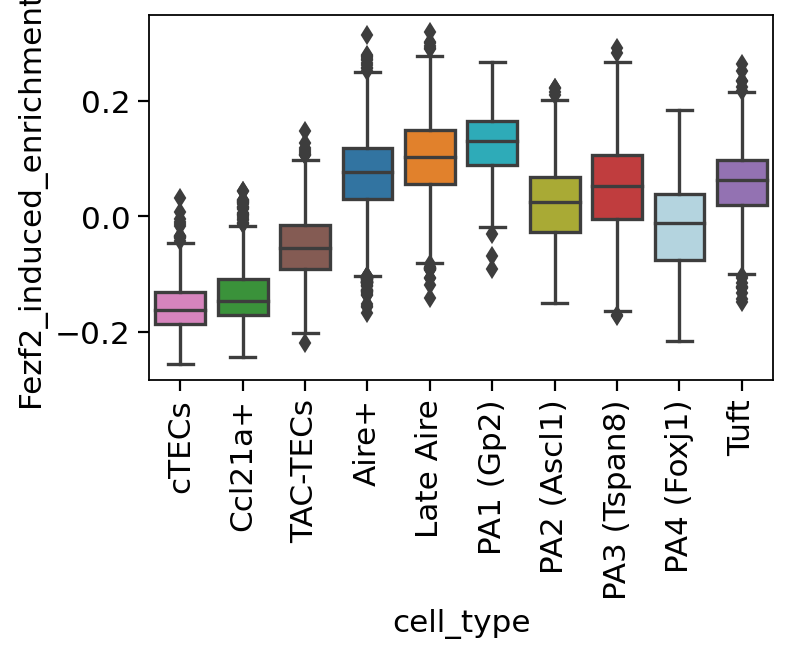

In [32]:
gene_list_enrichment_boxplot(
    adata[adata.obs.genotype == "WT"],
    gene_list=allClustersDownKO.index,
    key="Fezf2_induced_enrichment",
    cell_type_list=["cTECs", "Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    palette=["tab:pink", "tab:green", "tab:brown", "tab:blue", "tab:orange", "tab:cyan", "tab:olive", "tab:red", "lightblue", "tab:purple"],
    save_path="../../analysis/Paper figs/S2 (Fezf2 KO)/S2D_Fezf2_induced_enrichment_all_cell_types.pdf"
)

## Up in Fezf2 KO

### All clusters

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


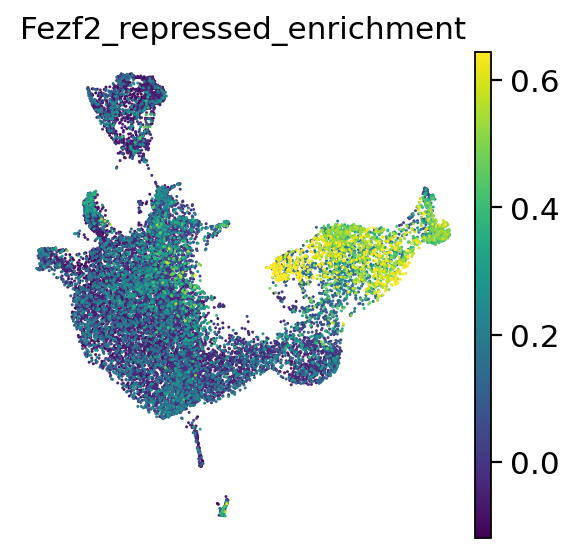

In [33]:
gene_list_enrichment_umap(
    adata[adata.obs.genotype == "WT"],
    gene_list=allClustersUpKO.index,
    key="Fezf2_repressed_enrichment",
    save_path="../../analysis/Paper figs/1 (Fezf2 KO)/1I"
)

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


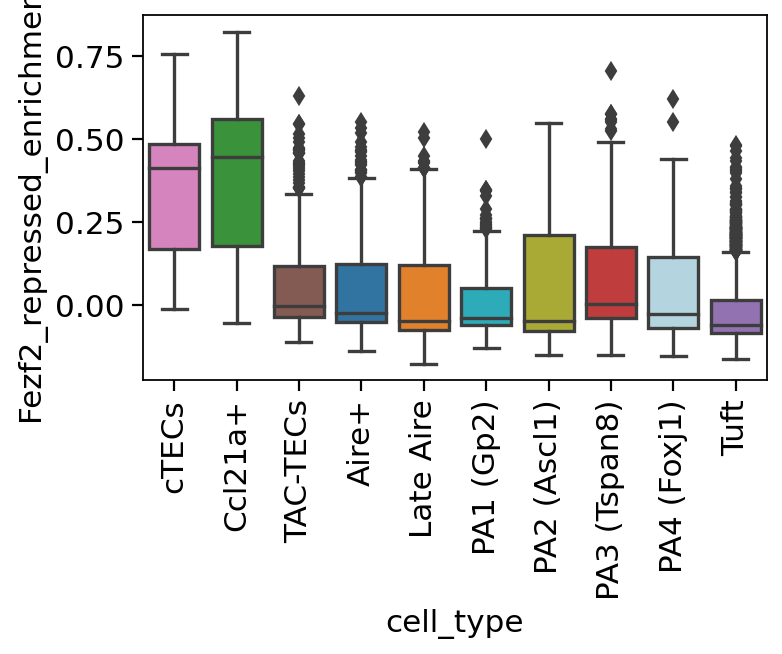

In [34]:
gene_list_enrichment_boxplot(
    adata[adata.obs.genotype == "WT"],
    gene_list=allClustersUpKO.index,
    key="Fezf2_repressed_enrichment",
    cell_type_list=["cTECs", "Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    palette=["tab:pink", "tab:green", "tab:brown", "tab:blue", "tab:orange", "tab:cyan", "tab:olive", "tab:red", "lightblue", "tab:purple"],
    save_path="../../analysis/Paper figs/S2 (Fezf2 KO)/S2D_Fezf2_repressed_enrichment_all_cell_types.pdf"
)